In [1]:
import sys; sys.path.append("/home/dictus/dmt")

In [2]:
from validations import CellDensityValidation, InhibitoryProportionValidation, StructuredAnalysis, SynapseDensityValidation, ConnectionProbabilityValidation

In [3]:
from neuro_dmt.models.bluebrain.circuit import CircuitAdapter, CircuitModel
from neuro_dmt.models.bluebrain.circuit.atlas import CircuitAtlas

In [4]:
# TODO: needing to import the measurement to provide data associated with it is slightly tedious and unnecessary.
#       perhaps the old system of 'samples' is better - the validation already knows what the measurement is
#       if we like we can always provide the measurement as metadata
#       this current entanglement of Test and Data is not ideal
from validations.measurements import cell_density, inhibitory_proportion, synapse_density, connection_probability
from neuro_dmt.terminology import neuroscience
import pandas as pd

ByLayerCellDensityData = pd.DataFrame({
    neuroscience.layer: [],
    cell_density: []})
ByLayerInhibitoryProportionData = pd.DataFrame({
    neuroscience.layer: [],
    inhibitory_proportion: []})
ByLayerSynapseDensityData = pd.DataFrame({
    neuroscience.layer: [],
    synapse_density: []})
ConnectionProbabilityData = pd.DataFrame({
    neuroscience.presynaptic: [],
    neuroscience.postsynaptic: [],
    connection_probability: []
})

In [5]:
circuit_config = "/gpfs/bbp.cscs.ch/project/proj83/circuits/Bio_M/20191206/CircuitConfig"
atlas_dir = "/gpfs/bbp.cscs.ch/project/proj83/data/atlas/S1/MEAN/P14-MEAN/"
adapter_model = CircuitAdapter(), CircuitModel(circuit_config)
adapter_model[1].label='circuit'
adapter_atlas = CircuitAdapter(), CircuitAtlas(atlas_dir)
adapter_atlas[1].label='atlas'

100%|████████████████████████████████████████████| 6/6 [00:34<00:00,  5.78s/it]


[<Figure size 999.113x576 with 1 Axes>]

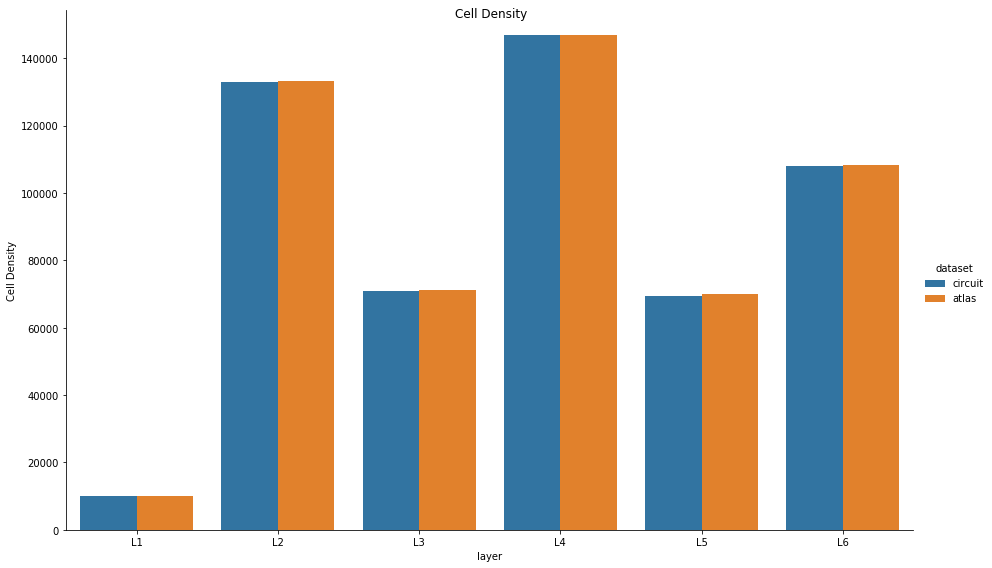

In [7]:
# TODO: simplevalidation should raise an error when called empty
report = CellDensityValidation.with_fields(measurement_parameters=pd.DataFrame({neuroscience.layer: ['L{}'.format(l) for l in range(1, 7)]}))(adapter_model, adapter_atlas)
#InhibitoryProportionValidation.with_fields(reference_data=ByLayerInhibitoryProportionData)(adapter_model)
#SynapseDensityValidation.with_fields(reference_data=ByLayerSynapseDensityData)(adapter_model)
report.figures

In [ ]:
from validations.parameters import ByHeight, ByMtypeByEtype
CellDensityValidation.with_fields(measurement_parameters=ByHeight(nbins=100))(adapter_model)

In [ ]:
from dmt.tk.terminology import Term
def etype_fraction(adapter, model, **parameters):
    ##rheqadjsvghabfjkbajkf
    return adapter.get_cell_density(**{p:v for p, v in parameters.items() if p != neuroscience.etype})\
           / adapter.get_cell_density(**parameters)
    
etype_fraction.phenomenon = Term("etype fraction", "fraction of cells belonging to etype")

In [ ]:
from dmt.tk.plotting import HeatPlot
EtypeFractionByEtypeMtype = CellDensityValidation.with_fields(
    plotter=HeatPlot(), measurement_parameters=ByMtypeByEtype(), measurement_method=etype_fraction)
EtypeFractionByEtypeMtype(adapter_model)

In [ ]:
from dmt.tk.plotting import CrossPlot
# TODO: make a crossplot that works without providing tons of data at initialization

In [ ]:
import numpy as np
class CentralConnectomeCircuitModel(CircuitModel):
    
    def define_central_column(self, cells):
        radius = 350 # um
        orientation = np.mean(cells.orientation, axis=0)[:, 1]
        origin = np.mean([cells.x, cells.y, cells.z], axis=1)
        return (radius, orientation, origin)
    
    def filter_central_column(self, column, cells):
        radius, orientation, origin = column
        positions = np.transpose([cells.x, cells.y, cells.z])
        differences = positions - origin
        parallel_component = np.sum(differences * orientation, axis=-1)[:, np.newaxis] * orientation[np.newaxis, :]
        perpendicular_component_size = np.linalg.norm(differences - parallel_component, axis=-1)
        return cells[perpendicular_component_size < radius]
    
    @property
    def central_column(self):
        if not hasattr(self, '_column'):
            self._column = self.define_central_column(self._circuit.cells.get())
        return self._column
    
    def get_cells(self, **params):
        cells = super().get_cells(**params)
        return self.filter_central_column(self.central_column, cells)
    
    def _sample_connectome(self, method, sample_size, **parameters):
        connectome = self.get_connectome(**parameters)
        pre_cells = self.get_cells(**parameters[neuroscience.presynaptic])
        post_cells = self.get_cells(**parameters[neuroscience.postsynaptic])
        # column = self.define_central_column(pd.concat([pre_cells, post_cells]))
        # pre_cells = self.filter_central_column(column, pre_cells)
        # post_cells = self.filter_central_column(column, post_cells)
        total_pairs = pre_cells.shape[0] * post_cells.shape[0]
        if total_pairs == 0:
            return np.nan
        return method(connectome, pre_cells.index.values, post_cells.index.values, sample_size)

In [ ]:
from validations.measurements import ConnectionProbabilityMeasurement, SynapsesPerConnectionMeasurement, PathwaySynapsesMeasurement
from validations.parameters import MtypeMtypePathways
from dmt.tk.plotting import HeatPlot, CirclePlot

ConnectomeValidation = CellDensityValidation.with_fields(measurement_parameters=MtypeMtypePathways(), plotter=HeatPlot())

cmodel = CentralConnectomeCircuitModel(circuit_config)
print(cmodel.mtypes())

#connprobreport=ConnectomeValidation.with_fields(measurement_method=ConnectionProbabilityMeasurement())((CircuitAdapter(), CentralConnectomeCircuitModel(circuit_config)))
#synconnreport=ConnectomeValidation.with_fields(measurement_method=SynapsesPerConnectionMeasurement())((CircuitAdapter(), CentralConnectomeCircuitModel(circuit_config)))
pathsynreport=ConnectomeValidation.with_fields(measurement_method=PathwaySynapsesMeasurement(sample_size=50), plotter=CirclePlot())((CircuitAdapter(), cmodel))

[{'layer': 'L1', 'morphology_subclass': 'DAC', 'mtype': 'L1_DAC'}, {'layer': 'L1', 'morphology_subclass': 'HAC', 'mtype': 'L1_HAC'}, {'layer': 'L1', 'morphology_subclass': 'LAC', 'mtype': 'L1_LAC'}, {'layer': 'L1', 'morphology_subclass': 'NGC-DA', 'mtype': 'L1_NGC-DA'}, {'layer': 'L1', 'morphology_subclass': 'NGC-SA', 'mtype': 'L1_NGC-SA'}, {'layer': 'L1', 'morphology_subclass': 'SAC', 'mtype': 'L1_SAC'}, {'layer': ['L2', 'L3'], 'morphology_subclass': 'BP', 'mtype': 'L23_BP'}, {'layer': ['L2', 'L3'], 'morphology_subclass': 'BTC', 'mtype': 'L23_BTC'}, {'layer': ['L2', 'L3'], 'morphology_subclass': 'CHC', 'mtype': 'L23_CHC'}, {'layer': ['L2', 'L3'], 'morphology_subclass': 'DBC', 'mtype': 'L23_DBC'}, {'layer': ['L2', 'L3'], 'morphology_subclass': 'LBC', 'mtype': 'L23_LBC'}, {'layer': ['L2', 'L3'], 'morphology_subclass': 'MC', 'mtype': 'L23_MC'}, {'layer': ['L2', 'L3'], 'morphology_subclass': 'NBC', 'mtype': 'L23_NBC'}, {'layer': ['L2', 'L3'], 'morphology_subclass': 'NGC', 'mtype': 'L23_NG

 38%|████████████▉                     | 1370/3600 [1:11:23<5:01:26,  8.11s/it]